### Exercise 8

Use policy gradients to solve OpenAI Gym’s LunarLander-v2 environment.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gym

In [37]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [2]:
# GPU training sucks on Mac, as usual
tf.config.set_visible_devices([], 'GPU')

In [3]:
gym.envs.registry['LunarLander-v2']

EnvSpec(id='LunarLander-v2', entry_point='gym.envs.box2d.lunar_lander:LunarLander', reward_threshold=200, nondeterministic=False, max_episode_steps=1000, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='LunarLander', version=2)

This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

**Action Space**

There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space**

The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.
Starting State

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

**Episode Termination**

The episode finishes if:

- the lander crashes (the lander body gets in contact with the moon);

- the lander gets outside of the viewport (x coordinate is greater than 1);

- the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:


In [4]:
# Description of the environment: https://www.gymlibrary.dev/environments/box2d/lunar_lander/
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [5]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.23264714,  0.32046658, -0.00265488,
       -0.05269808,  0.        ,  0.        ], dtype=float32)

In [6]:
env.action_space

Discrete(4)

In [7]:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [8]:
img = env.render()
img.shape

(400, 600, 3)

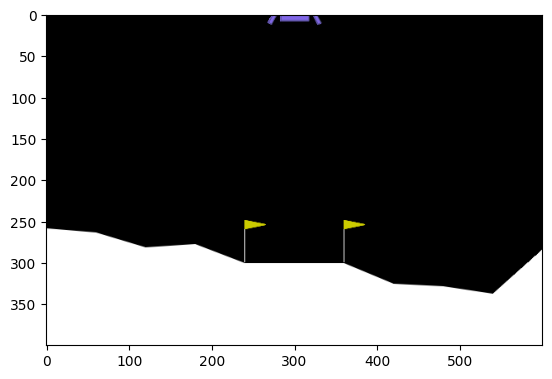

In [9]:
plt.imshow(img)

In [10]:
action = 2  # fire main engine
obs, reward, done, truncated, info = env.step(action)
obs

/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


array([ 0.00443649,  1.4258697 ,  0.21735123,  0.3439435 , -0.00602619,
       -0.06743155,  0.        ,  0.        ], dtype=float32)

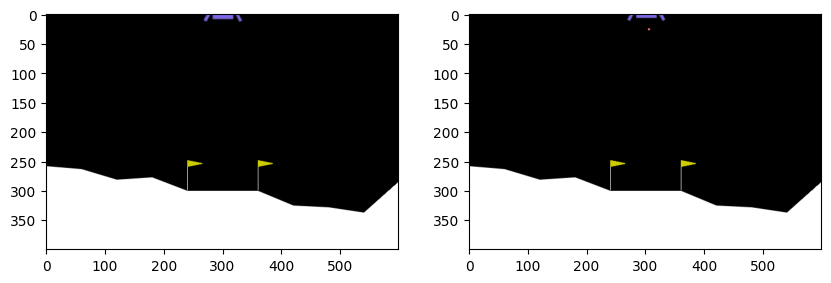

In [11]:
new_img = env.render()
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(new_img)

In [12]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img


In [13]:
# extra code – this cell displays an animation of one episode
import matplotlib.animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)


Let's create a small Neural Network for Policy Gradients. The network should have 8 inputs (the dimensions of the observation space) and 4 outputs, since we have 4 discrete actions

We should use the softmax activation function in the output layer. 

In [14]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [15]:
# Run this a few times to verify that np.round() yields numbers that strictly sum up to 1
for _ in range(100):
    probas = tf.cast(model(np.random.normal(size=(1, 8))), tf.float64)
    probas = probas / np.sum(probas)
    action = np.random.choice(4, p=probas[0])

In [16]:
probas

<tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[0.19165027, 0.05967217, 0.18899156, 0.559686  ]])>

In [17]:
np.array([[action]]).shape

(1, 1)

In [18]:
# we pretend that whatever action was chosen was the right one, so
# we can compute a loss and the associated gradients
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis]) # reshape to get the batch dimension

        # avoid rounding errors in np.random.choice() below
        probas = tf.cast(probas, tf.float64)
        probas = probas / np.sum(probas)
        
        action = np.random.choice(4, p=probas[0]) # sample a random action according to the predicted probas
        probas = tf.cast(probas, tf.float32)  # Recast to float32
        y_target = np.array([[action]])  # I hope I am getting this right
        loss = tf.reduce_mean(loss_fn(y_target, probas))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(action)
    return obs, reward, done, truncated, grads

In [19]:
# Let's see if it works
obs, reward, done, truncated, grads =  play_one_step(env, obs, model, tf.keras.losses.sparse_categorical_crossentropy)

In [20]:
[grad.shape for grad in grads]

[TensorShape([8, 10]),
 TensorShape([10]),
 TensorShape([10, 10]),
 TensorShape([10]),
 TensorShape([10, 4]),
 TensorShape([4])]

In [21]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [22]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [23]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [24]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [53]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [54]:
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

In [55]:
obs, info = env.reset(seed=42)
# Training loop

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")
    mean_rewards.append(mean_reward)
          
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 33.7

We need to introduce a large penalty when the ship does not touch the ground, otherwise it will just hover indefinetely...

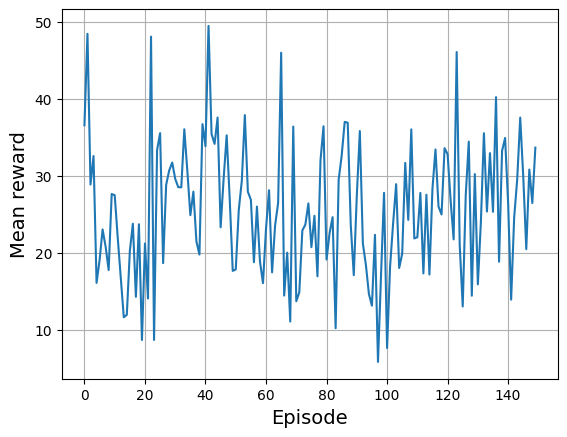

In [56]:
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [57]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    probas = model.predict(obs[np.newaxis], verbose=0)[0]
    return probas.argmax()

np.random.seed(42)
show_one_episode(pg_policy)

/Users/nikolaoschachampis/Library/Caches/pypoetry/virtualenvs/handson-ml3-DRIwlIAE-py3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
